In [33]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import os
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.functional import relu


In [39]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = sorted(os.listdir(images_dir))
        self.mask_files = sorted(os.listdir(masks_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Загружаем изображения и маски
        image_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        # Применение преобразований
        if self.transform:
            image = self.transform(image)

        # Преобразуем маску в тензор и убираем лишнюю размерность
        mask = transforms.ToTensor()(mask)  
        mask = mask.unsqueeze(0)

        return image, mask

In [4]:
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

In [12]:
# Пути к папкам с изображениями и масками
images_dir = 'datasets\Forest Segmented\Forest Segmented\images'
masks_dir = 'datasets\Forest Segmented\Forest Segmented\masks'

# Получаем список файлов
image_files = sorted(os.listdir(images_dir))
mask_files = sorted(os.listdir(masks_dir))


train_images, valid_images, train_masks, valid_masks = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42
)

# Создание датасетов
train_dataset = SegmentationDataset(
    images_dir=images_dir,
    masks_dir=masks_dir,
    transform=image_transform
)

valid_dataset = SegmentationDataset(
    images_dir=images_dir,
    masks_dir=masks_dir,
    transform=image_transform
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Valid dataset size: {len(valid_dataset)}")

Train dataset size: 5108
Valid dataset size: 5108


<>:2: SyntaxWarning: invalid escape sequence '\F'
<>:3: SyntaxWarning: invalid escape sequence '\F'
<>:2: SyntaxWarning: invalid escape sequence '\F'
<>:3: SyntaxWarning: invalid escape sequence '\F'
C:\Users\safar\AppData\Local\Temp\ipykernel_4632\3279264192.py:2: SyntaxWarning: invalid escape sequence '\F'
  images_dir = 'datasets\Forest Segmented\Forest Segmented\images'
C:\Users\safar\AppData\Local\Temp\ipykernel_4632\3279264192.py:3: SyntaxWarning: invalid escape sequence '\F'
  masks_dir = 'datasets\Forest Segmented\Forest Segmented\masks'


In [13]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

In [17]:
# Загрузка предобученной модели U-Net
#model = smp.Unet(
    #encoder_name='resnet50',        # Энкодер
    #encoder_weights='imagenet',    # Предобученные веса на ImageNet
    #in_channels=3,                 # Количество входных каналов (RGB = 3)
#     classes=1                      # Количество классов (для бинарной сегментации = 1)
# )
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [18]:
model=UNet(1)

In [43]:
# model.load_state_dict(torch.load("forest.pt", map_location=DEVICE))  # Загрузите веса
model.to(DEVICE)  # Переместите модель на устройство (GPU/CPU)
model.eval()

UNet(
  (e11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e51): Conv2d(512, 1024, kernel_size=(

In [44]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True )

In [21]:
import numpy as np

# Функция для вычисления IoU
def calculate_iou(true_mask, pred_mask):
    intersection = np.sum(true_mask * pred_mask)
    union = np.sum(true_mask) + np.sum(pred_mask) - intersection
    return intersection / union if union != 0 else 0

# Функция для вычисления Dice Coefficient
def calculate_dice(true_mask, pred_mask):
    intersection = np.sum(true_mask * pred_mask)
    return (2.0 * intersection) / (np.sum(true_mask) + np.sum(pred_mask) + 1e-7)

# Функция для вычисления Accuracy
def calculate_accuracy(true_mask, pred_mask):
    correct_pixels = np.sum(true_mask == pred_mask)
    total_pixels = true_mask.size
    return correct_pixels / total_pixels

In [22]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_iou = 0.0
        train_dice = 0.0
        train_accuracy = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            outputs = outputs.unsqueeze(1)

            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            preds = torch.sigmoid(outputs).detach().cpu().numpy() > 0.5
            true_masks = masks.detach().cpu().numpy()

            train_iou += np.mean([calculate_iou(true_mask, pred_mask)
                                  for true_mask, pred_mask in zip(true_masks, preds)])
            train_dice += np.mean([calculate_dice(true_mask, pred_mask)
                                   for true_mask, pred_mask in zip(true_masks, preds)])
            train_accuracy += np.mean([calculate_accuracy(true_mask, pred_mask)
                                       for true_mask, pred_mask in zip(true_masks, preds)])

        # Валидация
        model.eval()
        valid_loss = 0.0
        valid_iou = 0.0
        valid_dice = 0.0
        valid_accuracy = 0.0
        with torch.no_grad():
            for images, masks in valid_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)

                outputs = outputs.unsqueeze(1)  # Добавляем размерность канала
                loss = criterion(outputs, masks)
                valid_loss += loss.item()

                preds = torch.sigmoid(outputs).detach().cpu().numpy() > 0.5
                true_masks = masks.detach().cpu().numpy()

                valid_iou += np.mean([calculate_iou(true_mask, pred_mask)
                                      for true_mask, pred_mask in zip(true_masks, preds)])
                valid_dice += np.mean([calculate_dice(true_mask, pred_mask)
                                       for true_mask, pred_mask in zip(true_masks, preds)])
                valid_accuracy += np.mean([calculate_accuracy(true_mask, pred_mask)
                                           for true_mask, pred_mask in zip(true_masks, preds)])

        train_loss /= len(train_loader)
        train_iou /= len(train_loader)
        train_dice /= len(train_loader)
        train_accuracy /= len(train_loader)

        valid_loss /= len(valid_loader)
        valid_iou /= len(valid_loader)
        valid_dice /= len(valid_loader)
        valid_accuracy /= len(valid_loader)

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}, Train Dice: {train_dice:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Valid Loss: {valid_loss:.4f}, Valid IoU: {valid_iou:.4f}, Valid Dice: {valid_dice:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

In [67]:
train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=50)

NameError: name 'relu' is not defined

In [57]:
torch.save(model, 'full_model.pt')

In [23]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import os
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Приводим к размеру, на котором обучалась модель
    transforms.ToTensor(),          # Конвертируем в тензор [0, 1]
    transforms.Normalize(           # Нормализация (если использовалась при обучении)
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:2: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:2: SyntaxWarning: invalid escape sequence '\F'
C:\Users\safar\AppData\Local\Temp\ipykernel_4632\3361323356.py:1: SyntaxWarning: invalid escape sequence '\F'
  image_path = 'datasets\Forest Segmented\Forest Segmented\images\855_sat_41.jpg'
C:\Users\safar\AppData\Local\Temp\ipykernel_4632\3361323356.py:2: SyntaxWarning: invalid escape sequence '\F'
  mask_path = 'datasets\Forest Segmented\Forest Segmented\masks\855_mask_41.jpg'


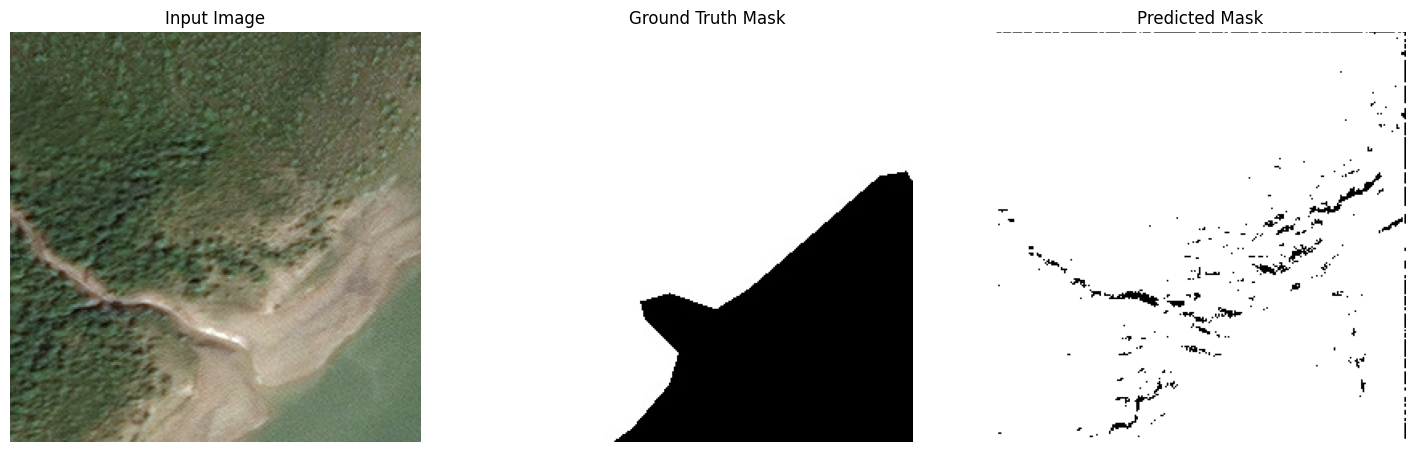

In [45]:
image_path = 'datasets\Forest Segmented\Forest Segmented\images\855_sat_41.jpg'
mask_path = 'datasets\Forest Segmented\Forest Segmented\masks\855_mask_41.jpg'


# Загрузка и предобработка изображения
image = Image.open(image_path).convert("RGB")
image_tensor = transform(image).unsqueeze(0).to(DEVICE)

# Загрузка истинной маски
true_mask = Image.open(mask_path).convert("L")  # Конвертация в оттенки серого
true_mask = np.array(true_mask.resize((256, 256))) / 255  # Изменение размера и нормализация [0, 1]

# Инференс
model.eval()
with torch.no_grad():
    output = model(image_tensor)
    pred_mask = torch.sigmoid(output).cpu().numpy()[0][0] > 0.5  # Бинаризация предсказания

plt.figure(figsize=(18, 6))

# Исходное изображение
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Input Image")
plt.axis("off")

# Истинная маска
plt.subplot(1, 3, 2)
plt.imshow(true_mask, cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

# Предсказанная маска
plt.subplot(1, 3, 3)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()

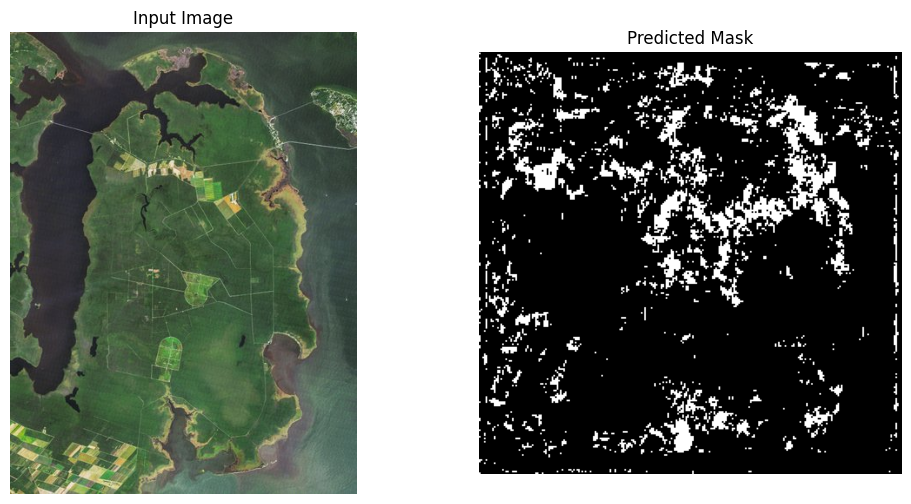

In [49]:
import requests
from io import BytesIO
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt

# Укажите URL изображения (можно заменить на любой другой)
image_url = "https://resizer.mail.ru/p/69a189b4-8353-5790-ac1d-aecc3d71b44f/AQAKMYkK5NCS2vMpRgzl_wmL6_CXueuxHJJ-L7rCBQXs54P03c0dCSZcA-40tO5Om8K2nFwNQILbtqMCgIDuTSqB3xM.jpg"  # Замените на реальный URL

# Загрузка изображения из интернета
response = requests.get(image_url)
image = Image.open(BytesIO(response.content)).convert("RGB")

# Преобразование изображения для модели
image_tensor = transform(image).unsqueeze(0).to(device)

# Предсказание маски
model.eval()
with torch.no_grad():
    output = model(image_tensor)
    pred_mask = torch.sigmoid(output).cpu().numpy()[0][0] > 0.5  # Бинаризация

# Визуализация (только исходное изображение и предсказание)
plt.figure(figsize=(12, 6))

# Исходное изображение
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Input Image")
plt.axis("off")

# Предсказанная маска
plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()